In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


def load_data():
    with open("../data/BMX_L.XPT", "rb") as f:
        df_body = pd.read_sas(f, format="xport")
    with open("../data/DEMO_L.XPT", "rb") as f:
        df_demo = pd.read_sas(f, format="xport")

    df = pd.merge(df_body, df_demo, on="SEQN")
    return df


def preprocess_data(df):
    age = df["RIDAGEYR"].to_numpy()  # Age in years (capped at 80)
    weight = df["BMXWT"].to_numpy()  # Weight in kg
    height = df["BMXHT"].to_numpy()  # Height in cm
    gender = df["RIAGENDR"].to_numpy()  # Gender (1: Male, 2: Female)

    stacked = np.stack((age, weight, height, gender), axis=1)
    stacked = stacked[~np.isnan(stacked).any(axis=1)]
    return stacked


def perform_linear_regression(X, y, tag, prediction_points=None):
    model = LinearRegression()
    model.fit(X, y)

    predictions = model.predict(
        prediction_points if prediction_points is not None else X
    )

    r_squared = model.score(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    residuals = y - predictions

    print(f"Slope: {slope:.2f}")
    print(f"Intercept: {intercept:.2f}")
    print(f"$R^2$: {r_squared:.3f}")

    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.scatter(X, y, edgecolors="white", linewidth=0.5)
        ax.plot(prediction_points, predictions, color="red")
        ax.set_xlabel("Age (years)")
        ax.set_ylabel("Height (cm)")
        plt.show()

    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.hist(residuals, bins=20, edgecolor="black", density=True)
        ax.set_xlabel("Residuals")
        ax.set_ylabel("Density")
        fig.tight_layout()
        plt.show()

    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.scatter(y, residuals, edgecolors="white", linewidth=0.5)
        ax.axhline(0, color="red", linestyle="--")
        ax.set_xlabel("Actual Height (cm)")
        ax.set_ylabel("Residuals (cm)")
        fig.tight_layout()
        plt.show()


def perform_polynomial_regression(X, y, degree, tag):
    poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_model.fit(X, y)

    predictions = poly_model.predict(X)
    r_squared = poly_model.score(X, y)

    mse = mean_squared_error(y, predictions)

    residuals = y - predictions

    print(f"$R^2$: {r_squared:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")

    argsorted_X = np.argsort(X.flatten())
    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.scatter(X, y, edgecolors="white", linewidth=0.5)
        ax.plot(X.flatten()[argsorted_X], predictions[argsorted_X], color="red")
        ax.set_xlabel("Age (years)")
        ax.set_ylabel("Height (cm)")
        fig.tight_layout()
        plt.show()

    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.hist(residuals, bins=20, edgecolor="black", density=True)
        ax.set_xlabel("Residuals")
        ax.set_ylabel("Density")
        fig.tight_layout()
        plt.show()

    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.scatter(y, residuals, edgecolors="white", linewidth=0.5)
        ax.axhline(0, color="red", linestyle="--")
        ax.set_xlabel("Actual Height (cm)")
        ax.set_ylabel("Residuals (cm)")
        fig.tight_layout()
        plt.show()


def perform_multifeature_higher_order_only(X, y, degree, tag):
    poly_features = PolynomialFeatures(degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)

    # Filter only the higher-order terms (e.g., x1^2, x2^2, etc.)
    higher_order_indices = [
        i
        for i, powers in enumerate(poly_features.powers_)
        if sum(powers) == max(powers)
    ]
    X_higher_order = X_poly[:, higher_order_indices]

    model = LinearRegression()
    model.fit(X_higher_order, y)
    predictions = model.predict(X_higher_order)
    r_squared = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)

    print(f"R^2 Score: {r_squared:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")

    residuals = y - predictions
    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.hist(residuals, bins=20, edgecolor="black", density=True)
        ax.set_xlabel("Residuals")
        ax.set_ylabel("Density")
        fig.tight_layout()
        plt.show()

    with plt.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.scatter(y, residuals, edgecolors="white", linewidth=0.5)
        ax.axhline(0, color="red", linestyle="--")
        ax.set_xlabel("Actual Height (cm)")
        ax.set_ylabel("Residuals (cm)")
        fig.tight_layout()
        plt.show()

In [2]:
df = load_data()
stacked = preprocess_data(df)

age = stacked[:, 0].reshape(-1, 1)
all_features = stacked[:, [0, 1, 3]]
height = stacked[:, 2]

Linear Regression: All Ages
Slope: 0.39
Intercept: 143.45
$R^2$: 0.237


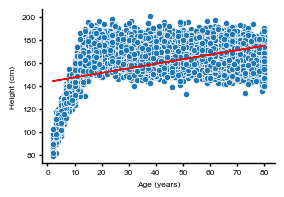

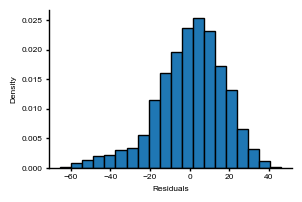

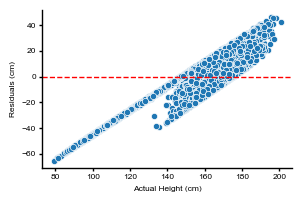

In [3]:
print("Linear Regression: All Ages")
perform_linear_regression(age, height, "all_ages", age)

Linear Regression: Ages ≤ 18
Slope: 5.08
Intercept: 89.27
$R^2$: 0.869


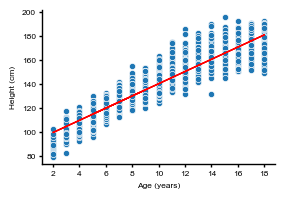

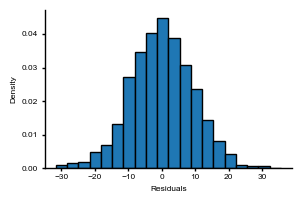

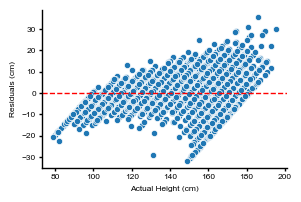

In [4]:
print("Linear Regression: Ages ≤ 18")
mask = age.flatten() <= 18
perform_linear_regression(age[mask], height[mask], "below_18", age[mask])

Polynomial Regression: Age to Height
$R^2$: 0.762
Mean Squared Error: 93.938


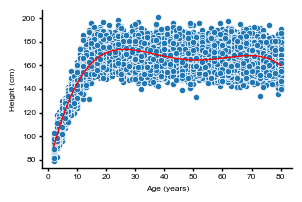

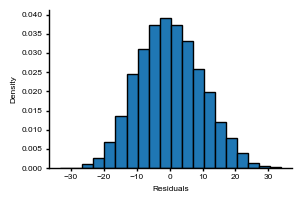

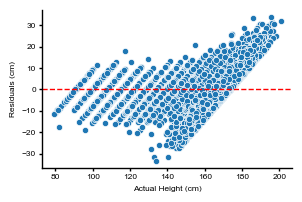

In [5]:
print("Polynomial Regression: Age to Height")
perform_polynomial_regression(age, height, degree=4, tag="single")

Multifeature Polynomial Regression
R^2 Score: 0.876
Mean Squared Error: 49.094


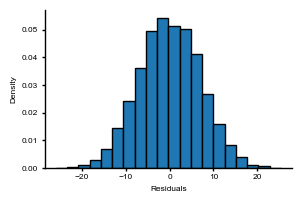

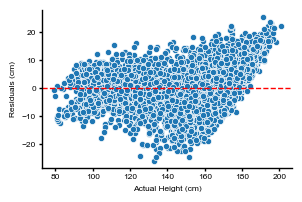

In [6]:
print("Multifeature Polynomial Regression")
perform_multifeature_higher_order_only(all_features, height, degree=4, tag="multi")